Copyright (c) Snap Inc. 2020. This sample code is made available by Snap Inc. for informational purposes only. It is provided as-is, without warranty of any kind, express or implied, including any warranties of merchantability, fitness for a particular purpose, or non-infringement. In no event will Snap Inc. be liable for any damages arising from the sample code or your use thereof.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import hashlib
import spacy
import os
import re
import json
from collections import OrderedDict
from operator import itemgetter
from spacy.lang.en.stop_words import STOP_WORDS
import string
import gensim
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBClassifier
import sys
sys.path.append('../')

from tf_idf_vectorizer import *
from utils.newsgroup_df_handle import *
from utils.EstimatorSelectionHelper import EstimatorSelectionHelper
from utils.classifier_setup import *

In [2]:
models = {
           "XGBoost" : XGBClassifier()
}

params = {'XGBoost':  {"colsample_bytree": [0.3,0.5,0.8,1],"gamma":[0,10,50,100],
                        "max_depth": [2,4,6], # default 3\
                        "n_estimators": [50,100], # default 100
                        "subsample": [0.3,0.5,0.8,1]}
}

def custom_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

In [ ]:
def prepare_dataframe_tf_idf(subset):
    df_with_keywords = pd.read_pickle('../../data/dataframes/df_'+subset+'_bugrepo_eclipse.pkl')
    articles = get_unique_combined_with_id(df_with_keywords, 'title', 'title')
    od_output, od_keys = get_tf_idf(articles, 'title', preprocessor=preprocessor, stop_words=stop_list, ngram_range = (1,1))
    print('Got TF-IDF vecs')
    df_with_keywords['tfidf_v1'] = df_with_keywords['id1'].apply(lambda x: od_output[list(od_keys).index(str(x))])
    print('Got v1')
    df_with_keywords['tfidf_v2'] = df_with_keywords['id2'].apply(lambda x: od_output[list(od_keys).index(str(x))])
    print(df_with_keywords.head())
    df_with_keywords['tfidf_similarity'] = df_with_keywords[['tfidf_v1','tfidf_v2']]\
                                        .apply(lambda row: cosine_similarity(row['tfidf_v1'],row['tfidf_v2'])[0][0], axis=1)
    
    return df_with_keywords

In [ ]:
# train_df = prepare_dataframe_tf_idf('train')
# test_df = prepare_dataframe_tf_idf('test')

In [ ]:
# train_df.to_pickle('../../data/dataframes/df_train_bugrepo_with_tf_idf_similarity.pkl')
# test_df.to_pickle('../../data/dataframes/df_test_bugrepo_with_tf_idf_similarity.pkl')

In [3]:
train_df = pd.read_pickle('../../data/dataframes/df_train_bugrepo_with_tf_idf_similarity.pkl')
test_df = pd.read_pickle('../../data/dataframes/df_test_bugrepo_with_tf_idf_similarity.pkl')

In [4]:
train_df['dup_issue'].value_counts()

True     40967
False    31175
Name: dup_issue, dtype: int64

# Event Similarity


In [5]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [6]:
helper_event = EstimatorSelectionHelper(models, params)

In [7]:
helper_event.fit(train_df['tfidf_similarity'].values.reshape(-1, 1),
            train_df['dup_issue'],
            cv = 5,
            scoring=make_scorer(custom_scorer, greater_is_better=True), n_jobs=16, refit=True)

Running GridSearchCV for XGBoost.
Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   15.9s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   35.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:  1.7min
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:  2.5min
[Parallel(n_jobs=16)]: Done 1920 out of 1920 | elapsed:  2.7min finished


--------------------XGBoost--------------------
Accuracy -  0.7574209245742093
Classfication Report - 
              precision    recall  f1-score   support

       False       0.73      0.84      0.78      4266
        True       0.80      0.66      0.72      3954

    accuracy                           0.76      8220
   macro avg       0.76      0.75      0.75      8220
weighted avg       0.76      0.76      0.76      8220

Confusion Matrix - 
[[0.84364744 0.15635256]
 [0.33560951 0.66439049]]


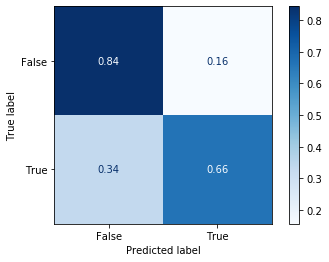

----------------------------------------


In [8]:
helper_event.summary(test_df['tfidf_similarity'], test_df['dup_issue'])

In [ ]:
# helper_event.save_models('../../data/models/', 'bugrepo_tfidf_event')

# Topical Similarity

In [10]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [11]:
helper_topic = EstimatorSelectionHelper(models, params)

In [ ]:
helper_topic.fit(train_df['tfidf_similarity'].values.reshape(-1, 1),
            train_df['dup_group'],
            cv = 5,
            scoring=make_scorer(custom_scorer, greater_is_better=True), n_jobs=16, refit=True)

Running GridSearchCV for XGBoost.
Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   15.8s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   35.9s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:  1.8min


In [ ]:
helper_topic.summary(test_df['tfidf_similarity'], test_df['dup_group'])